# Decision trees

Decision trees are a great way to get our feet wet with machine learning, because they are as transparent or white-box as can be. This means that they rank very high on explainability. In fact, you can see that no explanation is required, becaues the tree itself is the explanation. No equations needed!

Let's read our tennis data set. As we'll later see, it's the kind of data set that works especially well for tree-based models: the features and target are both categorical with few categories.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

tennis = pd.read_csv("tennis.csv")
tennis.head()

,day,outlook,temp,humidity,wind,play
0,D1,Sunny,Hot,High,Weak,No
1,D2,Sunny,Hot,High,Strong,No
2,D3,Overcast,Hot,High,Weak,Yes
3,D4,Rain,Mild,High,Weak,Yes
4,D5,Rain,Cool,Normal,Weak,Yes


And the first thing we will do is split our data into training and test sets. In this case, with the data being so small, the test set will be very limited. We will address this issue later.

In [2]:
from sklearn.model_selection import train_test_split 

X = tennis.drop(columns = ["play", "day"])
Y = tennis["play"]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.1, random_state = 99)
print(y_test)

0      No
12    Yes
Name: play, dtype: object


### Exercise

Note that `DecisionTreeClassifier` just like most other algorithms in `sklearn` don't directly work with categorical data: which includes `object` and `category` types. Uncomment the third line of the following code and run it to check the error message you get.

Documentation:

https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

In [3]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(criterion = 'entropy', max_depth = 3)

In [4]:
# Try running the following code:
tree.fit(X_train, y_train)

ValueError: could not convert string to float: 'Sunny'

### End of exercise

So we need to turn our categorical columns into numeric ones, using methods we learned earlier in our discussion about feature engineering. One option is to use `LabelEncoder`, which **remaps** or **recodes** the categories in a categorical column **into integers**. 

In [6]:
from sklearn.preprocessing import LabelEncoder
X_train_remap = X_train.copy()
X_test_remap = X_test.copy()

# First fit remapping on TRAIN set, apply (transform) both train/test.
for col in X_train_remap.columns:
    # Initialize/ re-initialize label encoder for the column
    le = LabelEncoder()
    # FIT the encoder on train set.
    le.fit(X_train[col])
    # Transform both the train and test set.
    X_train_remap[col] = le.transform(X_train[col])
    X_test_remap[col] = le.transform(X_test[col])
    # we can use this to print the mapping if we need to
    label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    print(label_mapping)

{'Overcast': 0, 'Rain': 1, 'Sunny': 2}
{'Cool': 0, 'Hot': 1, 'Mild': 2}
{'High': 0, 'Normal': 1}
{'Strong': 0, 'Weak': 1}


IMPORTANT: Notice that in the code above we run `fit` only **once** on the training data, but run `transform` **twice**: once on the training data and once on the test data.

Here's what the original data looks like.

In [7]:
X_train.head()

,outlook,temp,humidity,wind
7,Sunny,Mild,High,Weak
13,Rain,Mild,High,Strong
6,Overcast,Cool,Normal,Strong
5,Rain,Cool,Normal,Strong
4,Rain,Cool,Normal,Weak


Here's what `LabelEncoder` did with the data.

In [8]:
X_train_remap.head()

,outlook,temp,humidity,wind
7,2,2,0,1
13,1,2,0,0
6,0,0,1,0
5,1,0,1,0
4,1,0,1,1


Let's now see if we can train a decision tree.

In [9]:
tree_labelencoder = DecisionTreeClassifier(criterion = 'entropy', max_depth = 3)
tree_labelencoder.fit(X_train_remap, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=3)

This time we don't get an error. So using `LabelEncoder` did the trick. How how good is our tree at predicting? Let's get predictions on the test data.

In [10]:
y_pred_test = tree_labelencoder.predict(X_test_remap)
print(y_pred_test)

['No' 'Yes']


And let's compare the predictions with the labels on the test data.

In [11]:
y_test

0      No
12    Yes
Name: play, dtype: object

In [12]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred_test)

array([[1, 0],
       [0, 1]])

Two data points is not enough to judge a model's accuracy, but we will get to that later. How about visalizing the tree? We have a function for doing that. Make sure to change the path in the function below to point to the location of the `graphviz` library on your computer.

In [13]:
import os
from sklearn import tree

text_representation = tree.export_text(tree_labelencoder)
print(text_representation)

|--- feature_0 <= 0.50
|   |--- class: Yes
|--- feature_0 >  0.50
|   |--- feature_3 <= 0.50
|   |   |--- feature_1 <= 1.50
|   |   |   |--- class: No
|   |   |--- feature_1 >  1.50
|   |   |   |--- class: No
|   |--- feature_3 >  0.50
|   |   |--- feature_0 <= 1.50
|   |   |   |--- class: Yes
|   |   |--- feature_0 >  1.50
|   |   |   |--- class: No



In [ ]:
X_train.columns.values.tolist()

In [ ]:
fig = plt.figure(figsize=(15, 10))
feature_names = X_train.columns.values.tolist()
_ = tree.plot_tree(tree_labelencoder, feature_names=feature_names,
                   class_names=['No', 'Yes'], filled=True)

Take a good look at the tree and make sure you are comfortable with what it's saying. It's supposed to be "white-box" but is it? Something about the tree is a little **unnatural**: when we used `LabelEncoder` it assigned integers to each category of each feature and did it in the **alphabetical order** of the categories' names. If that choice seems arbitrary, it's because it is. By assigning integers to categories, we are implying that there is some sort of ordering. In our case this is fine, because our categorical features are **ordinal** meaning that there is a natural order: `sunny` > `overcast` > `rainy` for `outlook`, `hot` > `mild` > `cool` for `temp`, etc. But the alphabetical ordering used by `LabelEncoder` means that for example `mild` > `hot` > `cool`, which distorts the order. As a result a split like `outlook <= 1.5` is hard to interpret. As a general rule, encoding categorical columns like this is not a good idea and at best should only be done with **ordinal** data in a way that respects the order. 

With **nominal** data this should be avoided altogether. Instead we should turn to one-hot encoding.

In [ ]:
from sklearn.preprocessing import OneHotEncoder
onehot = OneHotEncoder(sparse = False, handle_unknown = "ignore")
onehot.fit(X_train)

Recall that `sklearn` transformations don't return nice-looking `DataFrame` objects. Instead they return `numpy` arrays, so it's up to us to convert the arrays back into `DataFrame` if we need to. In **production** we usually wouldn't need to do that, since we can pass the arrays directly to the ML algorithm for training and for scoring. But during **development** it can help us trace our steps and see intermediate results as we work toward the final product.

In [ ]:
onehot_col_names = onehot.get_feature_names(X_train.columns)
X_train_onehot = pd.DataFrame(onehot.transform(X_train), columns = onehot_col_names)
X_test_onehot = pd.DataFrame(onehot.transform(X_test), columns = onehot_col_names)

X_train_onehot.head()

### Generate and Evaluate the Model

In [ ]:
tree_onehot_ent = DecisionTreeClassifier(criterion = 'entropy', max_depth = 3)
tree_onehot_ent.fit(X_train_onehot, y_train)

In [ ]:
y_pred_test = tree_onehot_ent.predict(X_test_onehot)
y_pred_test

In [ ]:
y_test

Let's look at our confusion matrix.

In [5]:
confusion_matrix(y_test, y_pred_test)

NameError: name 'confusion_matrix' is not defined

What is different about our tree now? The big change is that because of one-hot encoding, each split of the tree is now a **binary split** happening at one of the categories: for example `outlook_sunny <= 0.5` means that if `outlook` is not `sunny` then we move to the left (True always moves to the left), otherwise we move to the right (False always moves to the left).

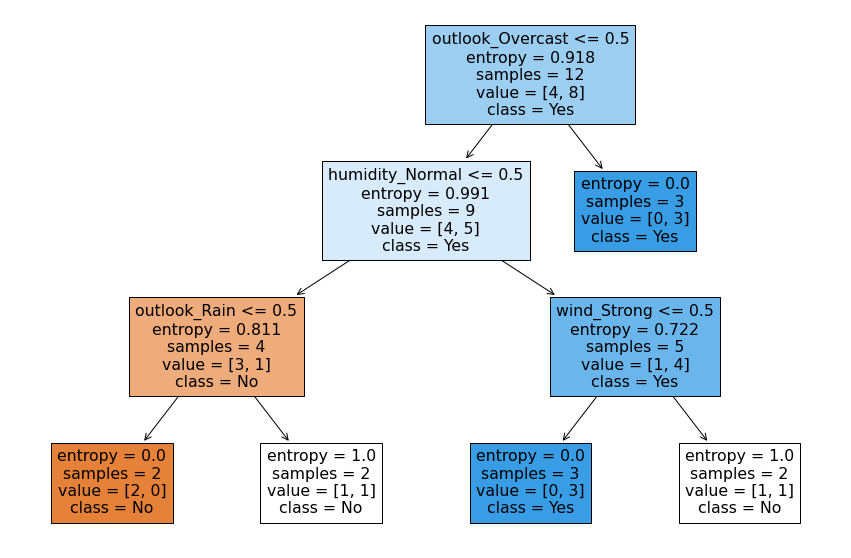

In [22]:
fig = plt.figure(figsize=(15, 10))
feature_names = X_train_onehot.columns.values.tolist()
_ = tree.plot_tree(tree_onehot_ent, feature_names=feature_names,
                   class_names=['No', 'Yes'], filled=True)

By default, the tree we used relied on **entropy** for its splitting criterion. Let's now see what happens if we use **Gini impurity** instead.

In [23]:
tree_onehot_gini = DecisionTreeClassifier(criterion = 'gini')
tree_onehot_gini.fit(X_train_onehot, y_train)

y_pred_test = tree_onehot_gini.predict(X_test_onehot)

Let's get the confusion matrix again.

In [24]:
confusion_matrix(y_test, y_pred_test)

array([[1, 0],
       [0, 1]])

And finally let's plot the tree.

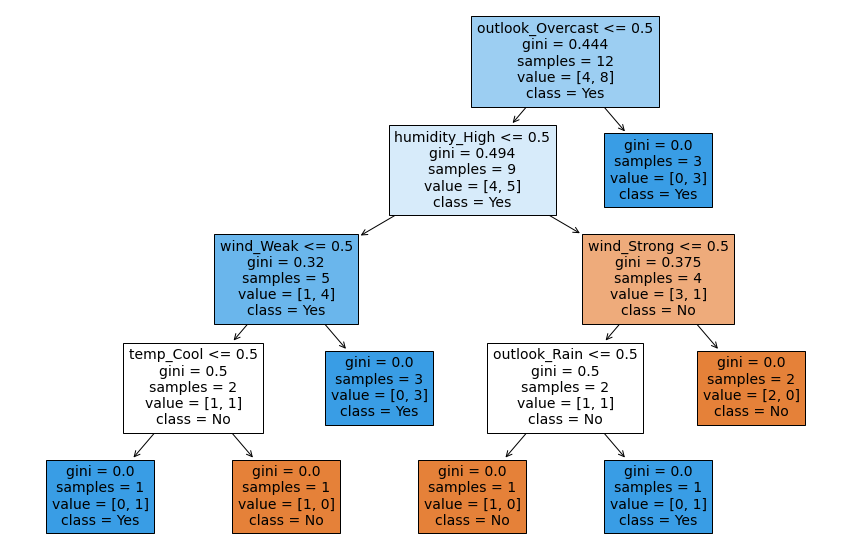

In [25]:
fig = plt.figure(figsize=(15, 10))
feature_names = X_train_onehot.columns.values.tolist()
_ = tree.plot_tree(tree_onehot_gini, feature_names=feature_names,
                   class_names=['No', 'Yes'], filled=True)

### Feature Importances

First we look at the gini reduction importances:

In [26]:
tree_onehot_gini.tree_.compute_feature_importances()

array([0.16666667, 0.1875    , 0.        , 0.1875    , 0.        ,
       0.        , 0.25208333, 0.        , 0.09375   , 0.1125    ])

In [27]:
features_importances = tree_onehot_gini.tree_.compute_feature_importances()

for feature_name, importance in zip(feature_names, features_importances):
    print('Col: {}, Gini Importance: {:.3f}'.format(feature_name, importance))

Col: outlook_Overcast, Gini Importance: 0.167
Col: outlook_Rain, Gini Importance: 0.187
Col: outlook_Sunny, Gini Importance: 0.000
Col: temp_Cool, Gini Importance: 0.187
Col: temp_Hot, Gini Importance: 0.000
Col: temp_Mild, Gini Importance: 0.000
Col: humidity_High, Gini Importance: 0.252
Col: humidity_Normal, Gini Importance: 0.000
Col: wind_Strong, Gini Importance: 0.094
Col: wind_Weak, Gini Importance: 0.112


In [28]:
# Entropy model:
features_importances = tree_onehot_ent.tree_.compute_feature_importances()

for feature_name, importance in zip(feature_names, features_importances):
    print('Col: {}, Gini Importance: {:.3f}'.format(feature_name, importance))

Col: outlook_Overcast, Gini Importance: 0.299
Col: outlook_Rain, Gini Importance: 0.177
Col: outlook_Sunny, Gini Importance: 0.000
Col: temp_Cool, Gini Importance: 0.000
Col: temp_Hot, Gini Importance: 0.000
Col: temp_Mild, Gini Importance: 0.000
Col: humidity_High, Gini Importance: 0.000
Col: humidity_Normal, Gini Importance: 0.294
Col: wind_Strong, Gini Importance: 0.229
Col: wind_Weak, Gini Importance: 0.000


### Permutation Importance

https://scikit-learn.org/stable/modules/generated/sklearn.inspection.permutation_importance.html

In [29]:
from sklearn.inspection import permutation_importance

result = permutation_importance(tree_onehot_gini, X_train_onehot, y_train, n_repeats=10, random_state=0)

In [30]:
print('Average Permuataion Importances: {}'.format(result.importances_mean))
print('Stdev. Permuataion Importances: {}'.format(result.importances_std))

Average Permuataion Importances: [0.275      0.075      0.         0.05       0.         0.
 0.24166667 0.         0.09166667 0.11666667]
Stdev. Permuataion Importances: [0.075      0.05833333 0.         0.04082483 0.         0.
 0.08700255 0.         0.05833333 0.07637626]


So far we trained three decision tree models, but with the test data consisting of only two rows, it's hard to evaluate the results and decide which model is better. What do we do in such situations? Depriving the training data of more data so we can have a bigger test data is definitely not a good solution. A better one is to just generate our own test data and try to simulate different situations and labeling it based on what we expect the label to be (we should be confident about our labels) and then predicting and evaluating the different models on this data. Of course generating such a data and making sure that it's representative of the training data is not always an easy task.

### More Data and Practice

It's time to put to practice everything that we learned. Let's read a new data set.

In [35]:
titanic = pd.read_csv('titanic.csv', sep = ',', header = 0)
titanic.columns = titanic.columns.str.lower() # use all lower case column names
print(titanic.shape)
titanic.head()
#show(titanic)


(891, 12)


,passengerid,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [36]:
target_col = 'survived'

titanic[target_col].value_counts(sort=True)

0    549
1    342
Name: survived, dtype: int64

The data consists of categorical features sech as `pclass`, `sex`, `sibsp`, `parch`, numeric features such as `fare`, and features that should be unique or almost unique per row such as `passengerid`, `name`, `cabin` and `ticket`.


Descriptions:

|        name | description |
|-------------|-------------|
| passengerid | Unique to each passenger |
|    survived | Target variable: Did the passenger survive? Yes=1, No=0 |
|      pclass | Passenger class, 1, 2, or 3 |
|        name | Passenger name |
|         sex | Passenger sex |
|         age | Passenger age |
|       sibsp | Number of siblings on board |
|       parch | Number of parents on board |
|      ticket | Ticket information |
|        fare | Fare paid |
|       cabin | Cabin Number |
|    embarked | Port of Origin: C = Cherbourg, Q = Queenstown, S = Southampton |

Train a decision tree classifier to predict who would survive the titanic shipwreck based on what we know about the passengers. This is an open exercise, so prior to training, you will need to make decisions about the following:

- which features should we keep in the model?
- what are some ways we may need to clean the data?
- what kind of feature engineering should we consider doing with the features we keep?

In [37]:
titanic['sex'] = titanic['sex'].map({'male': 0, 'female': 1})

Train a decision tree classifier to predict survival.

In [38]:
categorical = ['pclass', 'sex', 'sibsp', 'parch']
numeric = ['age', 'fare']
titanic.head()

,passengerid,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,NaN,S


In [39]:
# Let's drop NA rows:
titanic = titanic[[target_col] + categorical + numeric]
titanic = titanic.dropna()
titanic = titanic.reset_index(drop=True)
print(titanic.shape)
titanic.head()

(714, 7)


,survived,pclass,sex,sibsp,parch,age,fare
0,0,3,0,1,0,22.0,7.2500
1,1,1,1,1,0,38.0,71.2833
2,1,3,1,0,0,26.0,7.9250
3,1,1,1,1,0,35.0,53.1000
4,0,3,0,0,0,35.0,8.0500


In [40]:
# Let's one-hot encode categorical columns:
from sklearn.preprocessing import OneHotEncoder
onehot = OneHotEncoder(sparse = False, handle_unknown = "ignore")
onehot.fit(titanic[categorical])

X_categorical = pd.DataFrame(onehot.transform(titanic[categorical]),
                             columns = onehot.get_feature_names(titanic[categorical].columns))

X_categorical.head()

,pclass_1,pclass_2,pclass_3,sex_0,sex_1,sibsp_0,sibsp_1,sibsp_2,sibsp_3,sibsp_4,sibsp_5,parch_0,parch_1,parch_2,parch_3,parch_4,parch_5,parch_6
0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [52]:
# don't forget the numerical features:
X = pd.concat([X_categorical, titanic[numeric]], axis=1)

In [54]:
Y = titanic[target_col]

print("X data shape: {}".format(X.shape))
print("Y target shape: {}".format(Y.shape))
X.head()

X data shape: (714, 20)
Y target shape: (714,)


,pclass_1,pclass_2,pclass_3,sex_0,sex_1,sibsp_0,sibsp_1,sibsp_2,sibsp_3,sibsp_4,sibsp_5,parch_0,parch_1,parch_2,parch_3,parch_4,parch_5,parch_6,age,fare
0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,22.0,7.2500
1,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,38.0,71.2833
2,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,26.0,7.9250
3,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,35.0,53.1000
4,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,35.0,8.0500


In [55]:
# Split data set
from sklearn.model_selection import train_test_split 

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

# Split test into 50-50 test/validation
X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, test_size=0.5, random_state=1)

print('X train shape: {}'.format(X_train.shape))
print('X test shape: {}'.format(X_test.shape))
print('X valid stape: {}'.format(X_valid.shape))

X train shape: (571, 20)
X test shape: (71, 20)
X valid stape: (72, 20)


In [56]:
from sklearn.tree import DecisionTreeClassifier 

# Use entropy = no limit on samples for split
model_ent = DecisionTreeClassifier(criterion='entropy').fit(X_train, y_train) 
y_ent_pred = model_ent.predict(X_valid)

# Use information gain (default) limit min_samples to 4
model_gini = DecisionTreeClassifier(min_samples_leaf=4).fit(X_train, y_train)
y_gini_pred = model_gini.predict(X_valid)

# NOTE: Best practice when testing models, only vary 1 thing at a time.

In [57]:
# Generate an accuracy Score
from sklearn.metrics import accuracy_score

print("Entropy accuracy is : {:.2f}%".format(accuracy_score(y_valid, y_ent_pred)*100))
print("Gini accuracy is : {:.2f}%".format(accuracy_score(y_valid, y_gini_pred)*100))

Entropy accuracy is : 83.33%
Gini accuracy is : 81.94%


In [58]:
from sklearn.metrics import confusion_matrix

pd.DataFrame(
    confusion_matrix(y_valid, y_gini_pred),
    columns=['Predicted Died', 'Predicted Survived'],
    index=['True Died', 'True Survived']
)

,Predicted Died,Predicted Survived
True Died,41,6
True Survived,7,18


[Text(3897.0935947847684, 6272.307692307692, 'sex_1 <= 0.5\ngini = 0.483\nsamples = 571\nvalue = [338, 233]\nclass = No'),
 Text(2106.7906663907283, 5770.523076923077, 'pclass_1 <= 0.5\ngini = 0.321\nsamples = 358\nvalue = [286, 72]\nclass = No'),
 Text(749.1773592715232, 5268.738461538462, 'age <= 9.5\ngini = 0.243\nsamples = 275\nvalue = [236, 39]\nclass = No'),
 Text(184.7682119205298, 4766.953846153846, 'fare <= 20.825\ngini = 0.5\nsamples = 20\nvalue = [10, 10]\nclass = No'),
 Text(92.3841059602649, 4265.16923076923, 'gini = 0.0\nsamples = 7\nvalue = [0, 7]\nclass = Yes'),
 Text(277.1523178807947, 4265.16923076923, 'fare <= 30.256\ngini = 0.355\nsamples = 13\nvalue = [10, 3]\nclass = No'),
 Text(184.7682119205298, 3763.3846153846152, 'gini = 0.0\nsamples = 5\nvalue = [5, 0]\nclass = No'),
 Text(369.5364238410596, 3763.3846153846152, 'fare <= 39.344\ngini = 0.469\nsamples = 8\nvalue = [5, 3]\nclass = No'),
 Text(277.1523178807947, 3261.6, 'gini = 0.375\nsamples = 4\nvalue = [1, 3]\

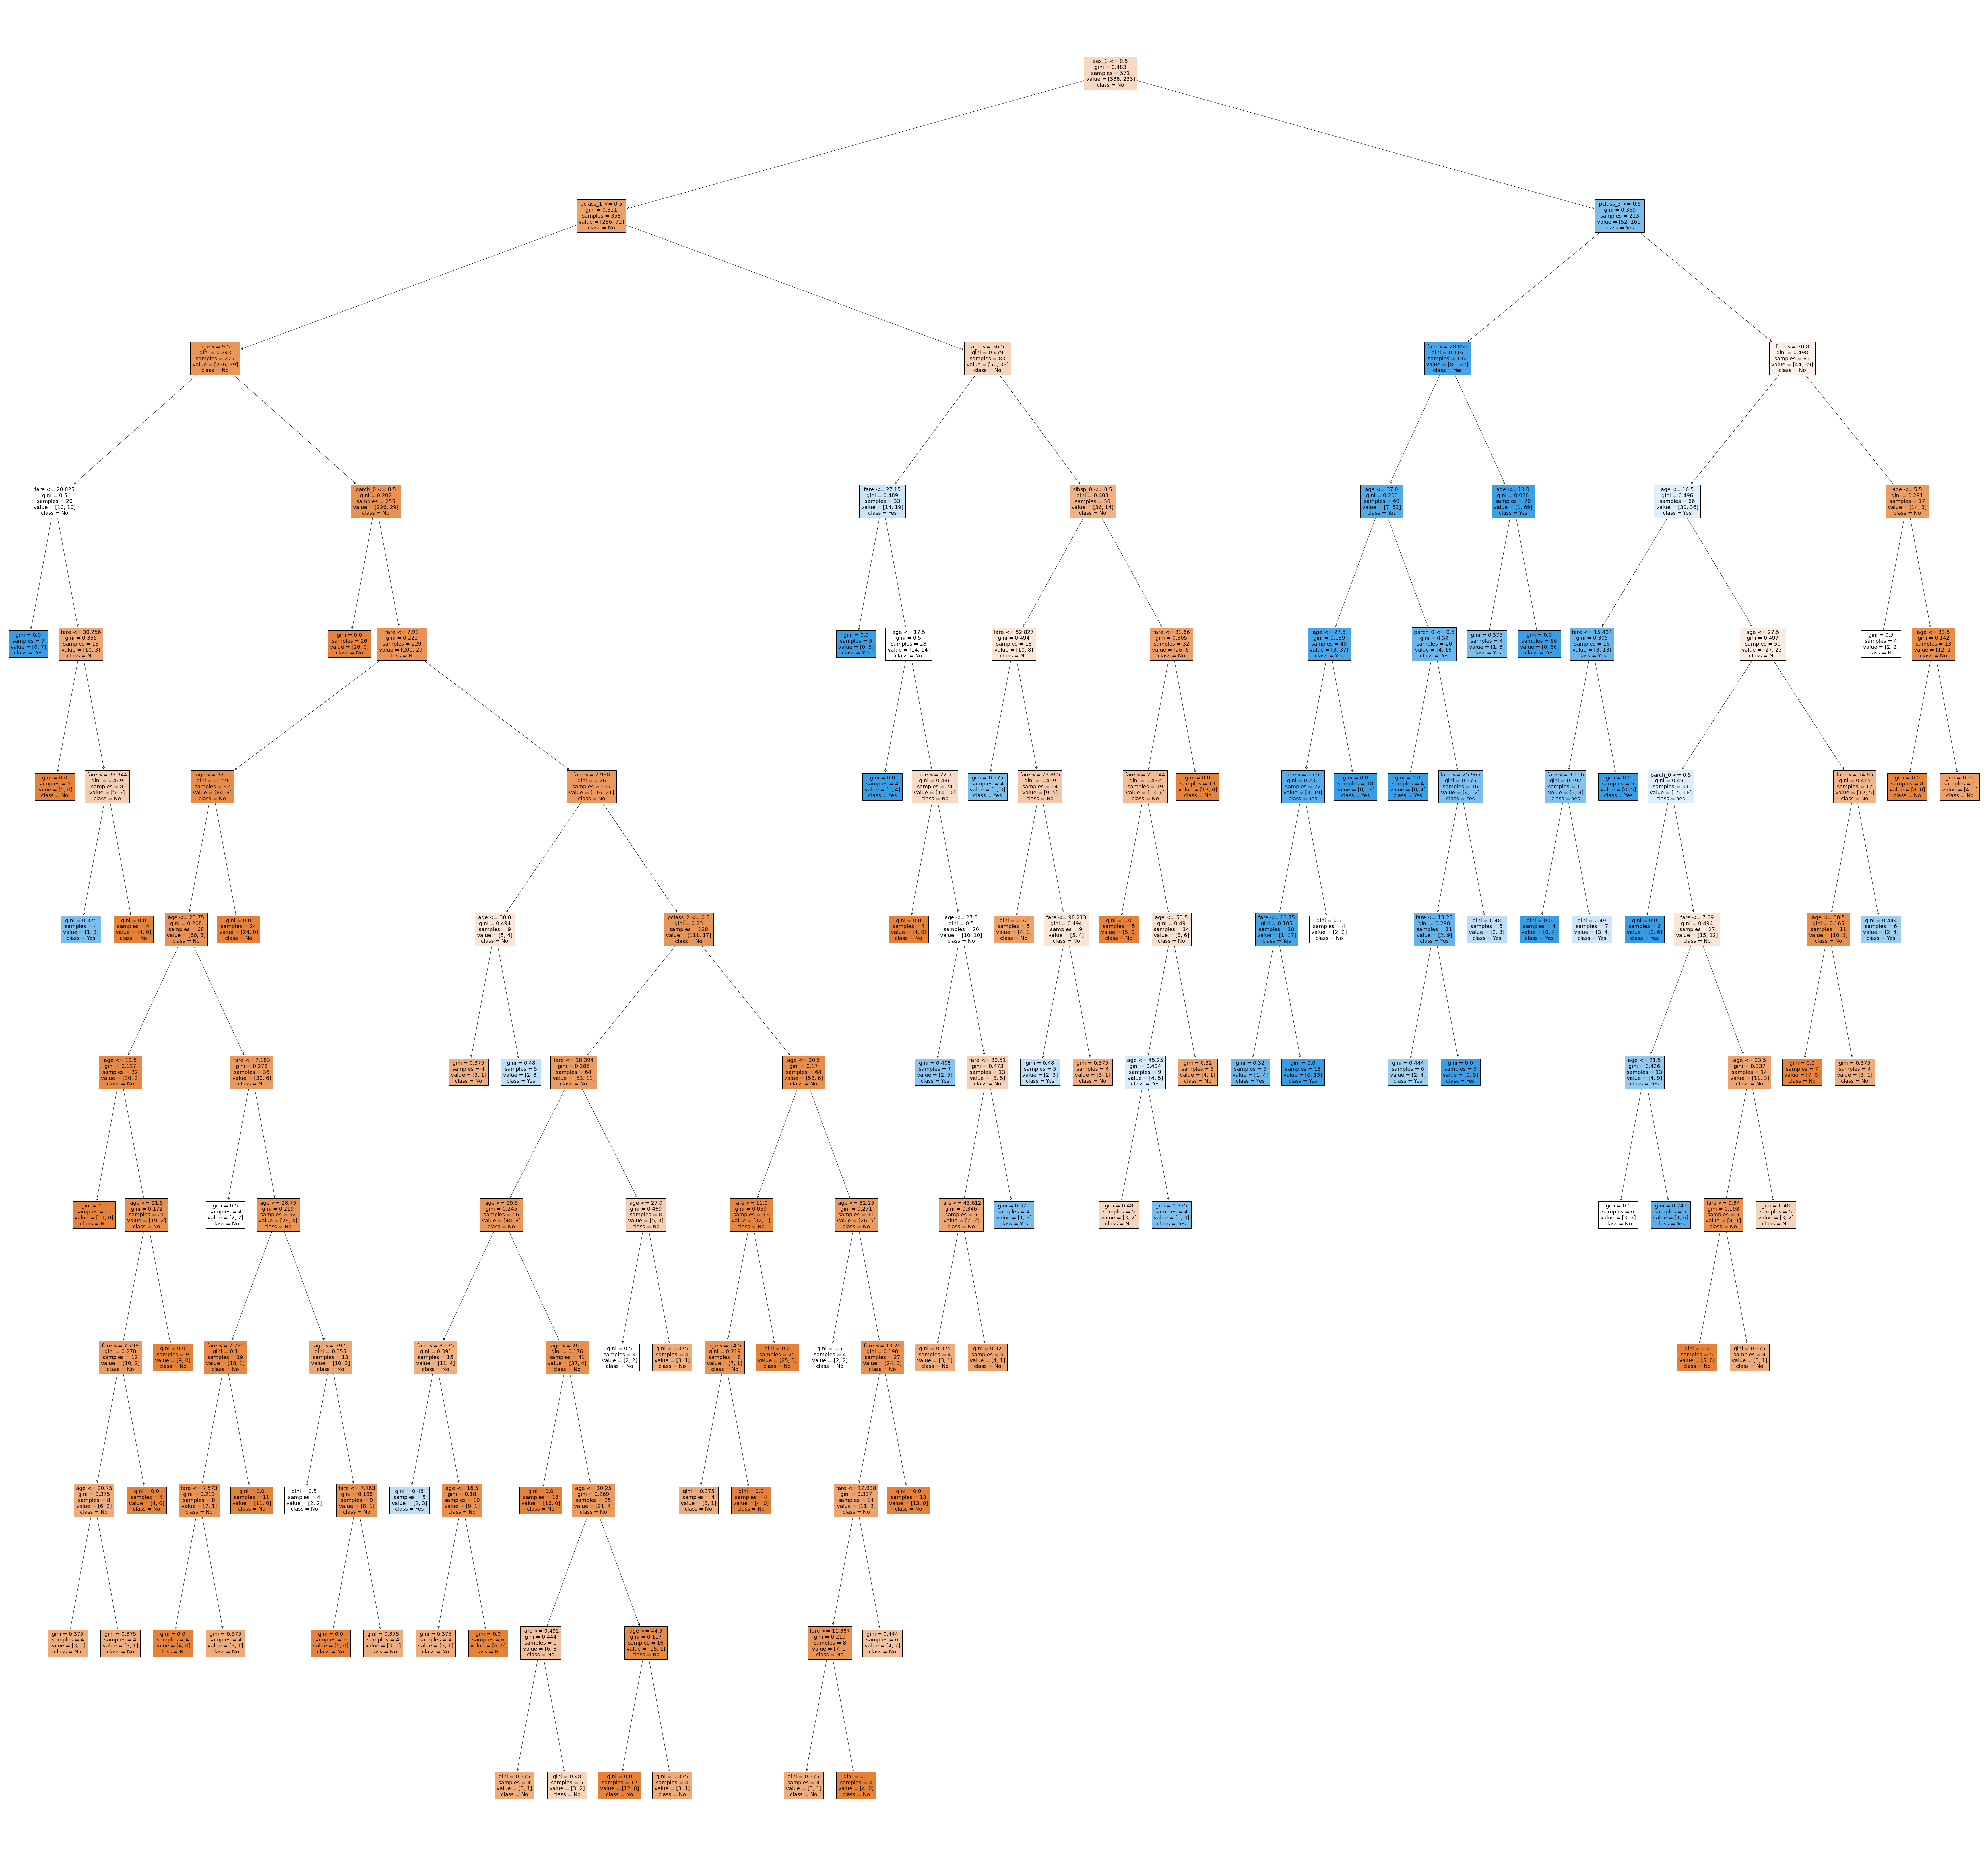

In [59]:
#create a visualization of the tree 
from sklearn import tree
import matplotlib.pyplot as plt


fig = plt.figure(figsize=(125, 120)) 
tree.plot_tree(model_gini,
               feature_names=X.columns,  
               class_names=['No', 'Yes'],
               filled=True)

Right click on image and "Save As" to open in an actual image viewer to zoom in.


Notes:

More red = Higher proportion of 0=Not Survive class.

### Feature importances:



In [ ]:
# Gini/Entropy Index
features_importances = model_ent.tree_.compute_feature_importances()

for feature_name, importance in zip(X.columns, features_importances):
    print('Col: {}, Gini Importance: {:.3f}'.format(feature_name, importance))

In [ ]:
# Permutation Importance:

result = permutation_importance(model_ent, X_train, y_train, n_repeats=10, random_state=0)

print('Average Permuataion Importances: {}'.format(result.importances_mean))
print('Stdev. Permuataion Importances: {}'.format(result.importances_std))

# Model Selection and Reporting on Test Set

Now that we have chosen, say, the entropy model, let's report accuracy.

In [ ]:
y_ent_pred_test = model_ent.predict(X_test)
print("Entropy TEST accuracy is : {:.2f}%".format(accuracy_score(y_test, y_ent_pred_test)*100))

In [ ]:
# What about other model?  As long as this doesn't influence our choice of model:
y_gini_pred_test = model_gini.predict(X_test)
print("Gini TEST accuracy is : {:.2f}%".format(accuracy_score(y_test, y_gini_pred_test)*100))